
# PTSD Model Inference with IRT Features

## [Center for Health Statistics](http://www.healthstats.org)

## [The Zero Knowledge Discovery Lab](http://zed.uchicago.edu)
---



In [1]:
import ccx as cx
import pylab as plt
plt.style.use('ggplot')
import pickle
import pandas as pd
%matplotlib inline

In [2]:
datafile='../../data/CAD-PTSDData.csv'

In [3]:
def processDATA(datafile):
    '''
        process data file 
        into training data X, target labels y
    '''
    Df=pd.read_csv(datafile)
    X=Df.drop(['record_id','PTSDDx'],axis=1).values
    y=Df.drop(['record_id'],axis=1).PTSDDx.values
    y[:60] = 2*np.ones([1,60])
    print(y)
    [nsamples,nfeatures]=X.shape
    return X,y,nfeatures,nsamples

In [4]:
X,y,nfeatures,nsamples=processDATA(datafile)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0
 1 0 0 1 1 0 0 0]


100%|██████████| 1000/1000 [00:01<00:00, 857.27it/s]


0


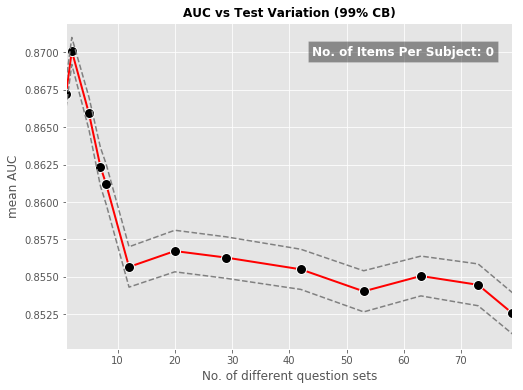

In [5]:
Perf23,Dperf23,Models23,Nitems23=cx.getSystem(X,y,max_depth=2,n_estimators=3)
print(Nitems23)
cx.PLOT(Dperf23,Nitems23,dn='23',pdfname='../models/dummy23.pdf')

100%|██████████| 1000/1000 [00:01<00:00, 857.47it/s]


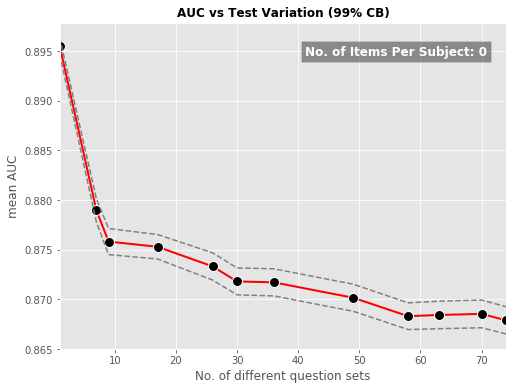

In [6]:
Perf32,Dperf32,Models32,Nitems32=cx.getSystem(X,y,max_depth=3,n_estimators=2)
cx.PLOT(Dperf32,Nitems32,dn='32',pdfname='../models/dummy32.pdf')

In [8]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def pickleModel(models,threshold=0.87,filename='model.pkl',verbose=True):
    '''
        save trained model set
    '''
    MODELS=[]
    for key,mds in models.items():
        if key >= threshold:
            mds_=[i[0] for i in mds]
            MODELS.extend(mds_)
    if verbose:
        print("number of models (tests):", len(MODELS))
        FS=getCoverage(MODELS,verbose=True)
        print("Item Use Fraction:", FS.size/(len(MODELS)+0.0))
    dump(MODELS, filename)
    return

In [19]:
getCoverage(Models32[0.8667022416009871][0])

('Number of items used: ', 13)


array([ 33., 171., 132., 179., 166., 172.,  11., 140.,  81., 146., 115.,
       181.,  22.])

In [7]:
cx.pickleModel(Models23,threshold=.885,filename='./dummy_model_2_3.pkl')
print("--")
cx.pickleModel(Models32,threshold=.9,filename='./dummy_model_3_2.pkl')

('number of models (tests):', 0)


AttributeError: 'list' object has no attribute 'size'